In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE = 4
EPOCHS = 100
data_dir = "/home/iai/Desktop/Jeewon/Seminar/20230112_MVtecAD/data/dataset_auto"

cuda


In [2]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()
    
    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

In [3]:
transform = transforms.Compose(
    [
    transforms.ToTensor(),
     ]
)

train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform)
mean_train, std_train = calculate_norm(train_dataset)
print(f'AVG(R,G,B): {mean_train}\nSTD(R,G,B): {std_train}')

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean_train, std_train),
])

train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
# print(train_dataset.classes)
print("size of train dataset : ", len(train_dataset))
print(train_dataset[0][0].shape)

AVG(R,G,B): (0.43187267, 0.40121475, 0.3912592)
STD(R,G,B): (0.18199517, 0.17286266, 0.16209516)
size of train dataset :  3629
torch.Size([3, 224, 224])


In [4]:
transform = transforms.Compose(
    [
    transforms.ToTensor(),
     ]
)

test_dataset = ImageFolder(os.path.join(data_dir, 'test'), transform)
mean_test, std_test = calculate_norm(test_dataset)
print(f'AVG(R,G,B): {mean_test}\nSTD(R,G,B): {std_test}')

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean_test, std_test),
])

test_dataset = ImageFolder(os.path.join(data_dir, 'test'), transform)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = 2)
# print(test_dataset.classes)
print("size of test dataset : ", len(test_dataset))
print(test_dataset[0][0].shape)

AVG(R,G,B): (0.43465692, 0.40982994, 0.40375176)
STD(R,G,B): (0.18914154, 0.18589146, 0.17603187)
size of test dataset :  1725
torch.Size([3, 224, 224])


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.8774) tensor(2.7123)
torch.Size([4, 3, 224, 224])
torch.float32


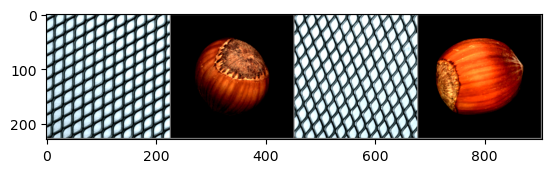

torch.Size([4, 3, 224, 224])


In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

print(images.shape)
print(images.dtype)

imshow(torchvision.utils.make_grid(images))
print(images.shape)

tensor(-1.6760) tensor(3.3872)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


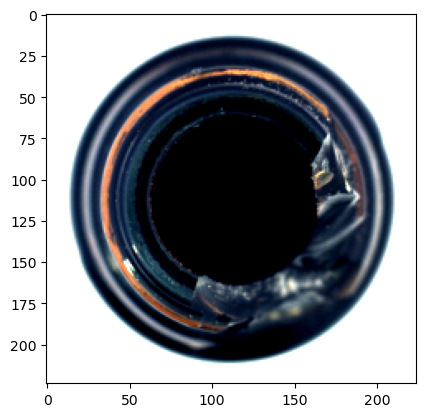

torch.Size([1, 3, 224, 224])


In [7]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [8]:
# CNN Autoencoder

class CNN_Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    # N, 3, 224, 224
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 16, 4, stride = 2, padding = 1), # N, 16, 112, 112
        nn.ReLU(),
        nn.Conv2d(16, 32, 4, stride = 2, padding = 1), # N, 32, 56, 56
        nn.ReLU(),
        nn.Conv2d(32, 64, 4, stride = 2, padding = 1), # N, 64, 28, 28
        nn.ReLU(),
        nn.Conv2d(64, 128, 4, stride = 2, padding = 1), # N, 128, 14, 14
        nn.ReLU(),
        nn.Conv2d(128, 256, 14) # N, 256, 1, 1
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 14),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 4, stride = 2, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 3, 4, stride = 2, padding = 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [9]:
model = CNN_Autoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [10]:
output_train = []
train_loss = []

for epoch in range(EPOCHS):
  for (img, _) in train_loader:
    # img = img.reshape(-1, 224*224*3)
    img = img.to(device)
    recon = model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  output_train.append((epoch, img, recon))

Epoch:1, Loss:1.0742
Epoch:2, Loss:1.8134
Epoch:3, Loss:0.5301
Epoch:4, Loss:1.8943
Epoch:5, Loss:0.4717
Epoch:6, Loss:1.9313
Epoch:7, Loss:1.8218
Epoch:8, Loss:2.8258
Epoch:9, Loss:1.8682
Epoch:10, Loss:1.0627
Epoch:11, Loss:0.6828
Epoch:12, Loss:1.8426
Epoch:13, Loss:1.9731
Epoch:14, Loss:1.0221
Epoch:15, Loss:0.9150
Epoch:16, Loss:0.6645
Epoch:17, Loss:2.8074
Epoch:18, Loss:0.8533
Epoch:19, Loss:2.3900
Epoch:20, Loss:2.8271
Epoch:21, Loss:2.3930
Epoch:22, Loss:0.4374
Epoch:23, Loss:0.4446
Epoch:24, Loss:0.1404
Epoch:25, Loss:0.3645
Epoch:26, Loss:2.8172
Epoch:27, Loss:1.0091
Epoch:28, Loss:0.4659
Epoch:29, Loss:0.3902
Epoch:30, Loss:0.5005
Epoch:31, Loss:1.9443
Epoch:32, Loss:1.8223
Epoch:33, Loss:1.7865
Epoch:34, Loss:0.6114
Epoch:35, Loss:0.7632
Epoch:36, Loss:2.3477
Epoch:37, Loss:1.0588
Epoch:38, Loss:0.4413
Epoch:39, Loss:2.3547
Epoch:40, Loss:1.5007
Epoch:41, Loss:1.0202
Epoch:42, Loss:2.2071
Epoch:43, Loss:2.8500
Epoch:44, Loss:2.5191
Epoch:45, Loss:0.2859
Epoch:46, Loss:0.83

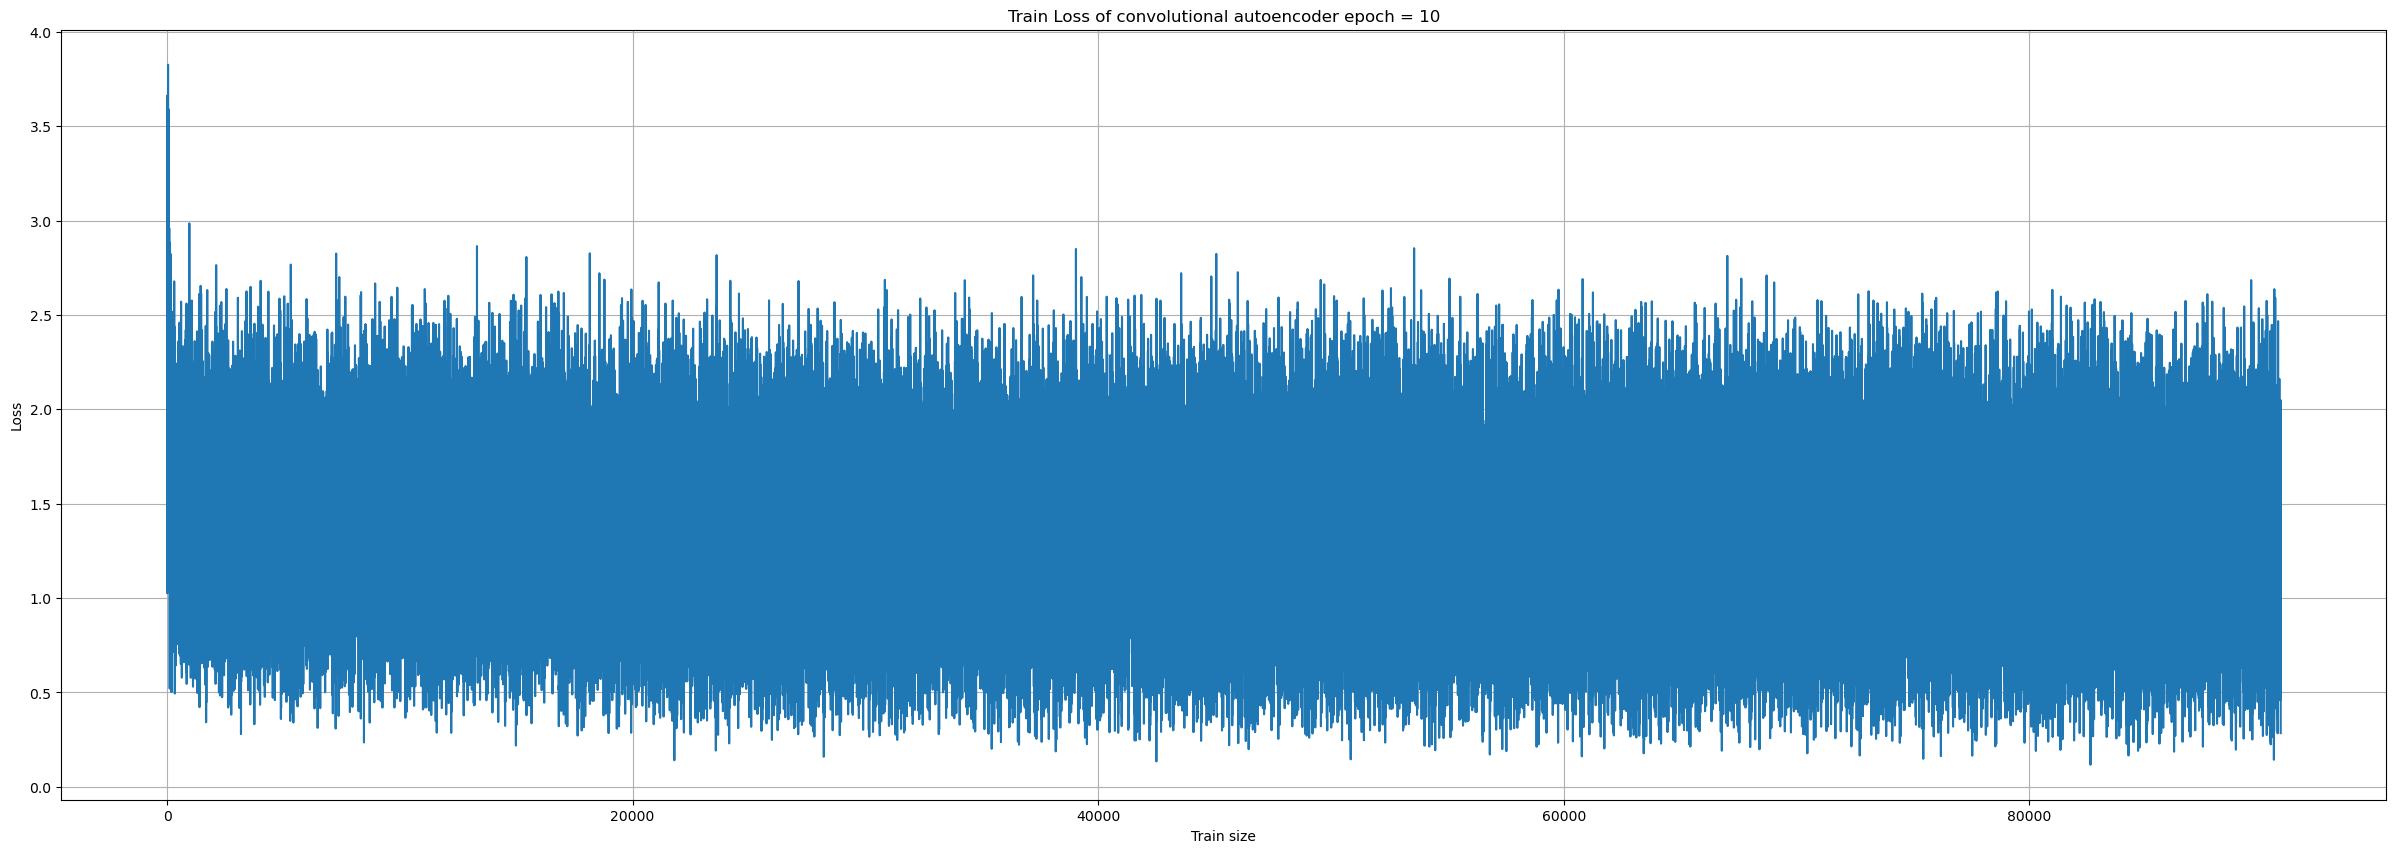

In [11]:
plt.figure(figsize=(30,10))
plt.plot(train_loss)
plt.grid()
plt.xlabel('Train size')
plt.ylabel('Loss')
plt.title('Train Loss of convolutional autoencoder epoch = 10')
plt.legend
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


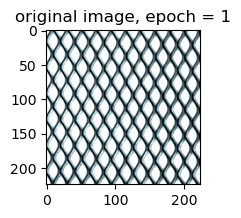

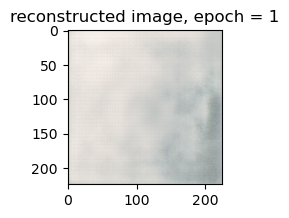

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


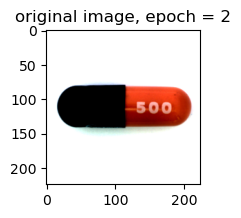

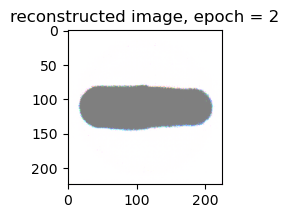

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


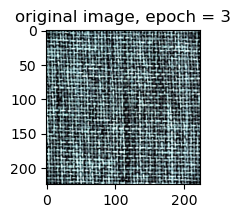

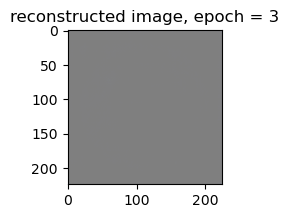

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


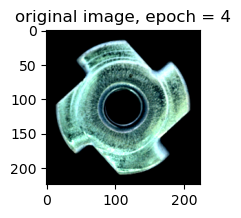

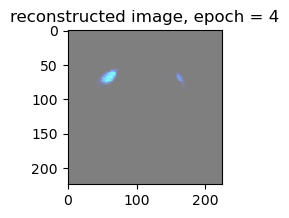

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


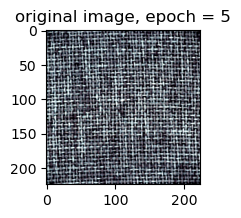

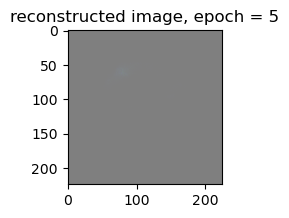

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


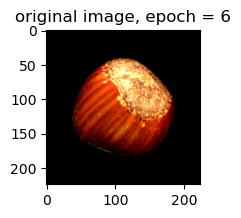

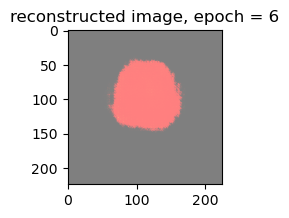

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


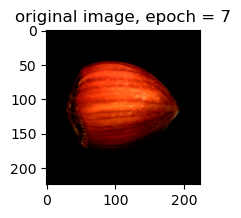

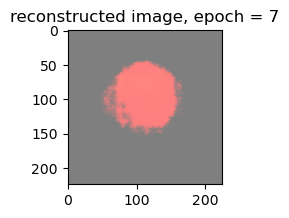

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


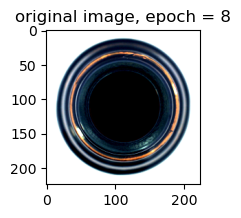

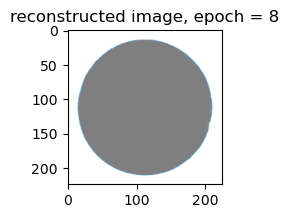

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


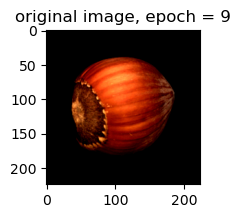

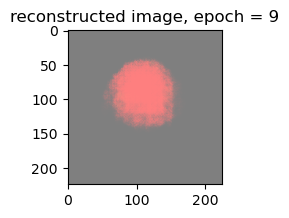

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


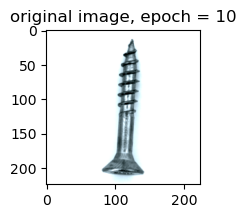

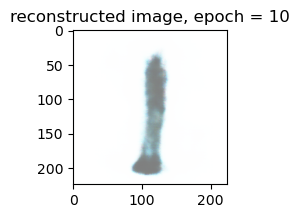

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


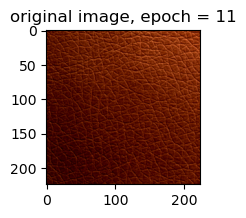

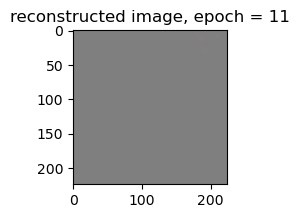

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


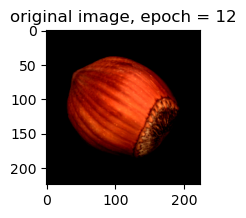

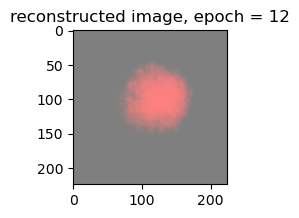

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


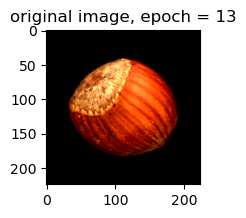

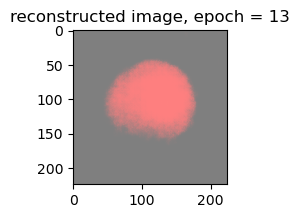

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


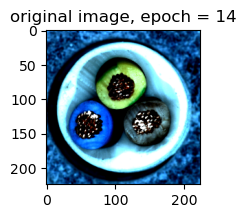

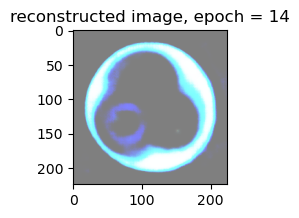

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


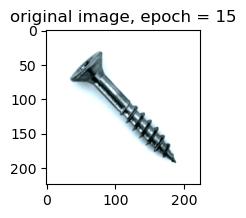

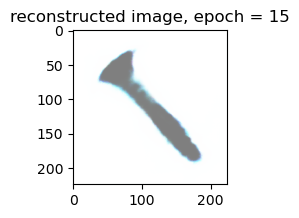

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


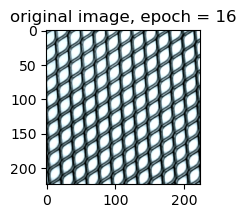

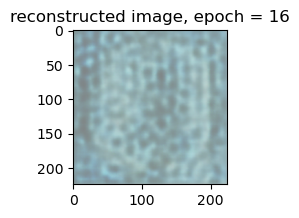

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


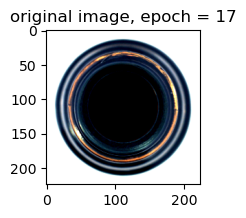

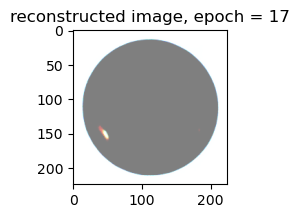

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


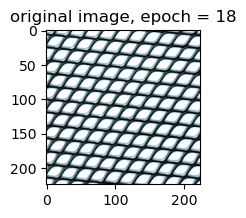

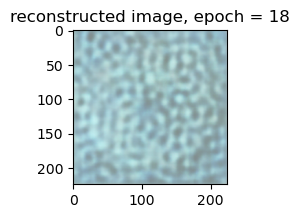

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


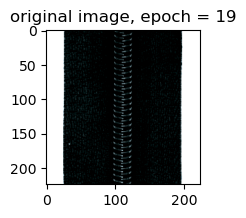

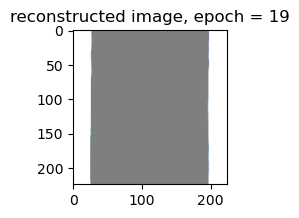

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


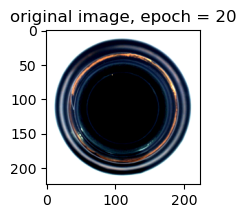

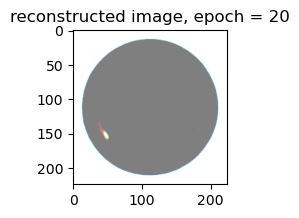

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


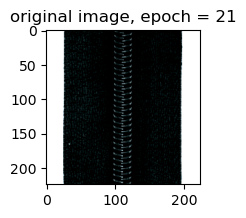

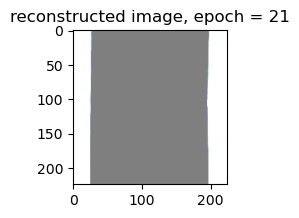

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


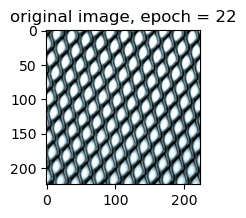

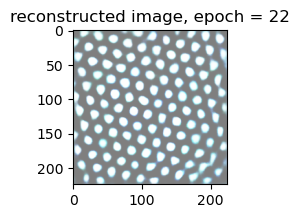

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


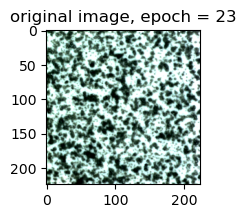

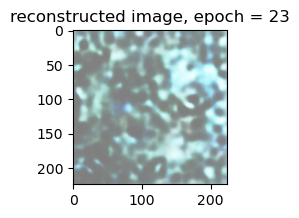

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


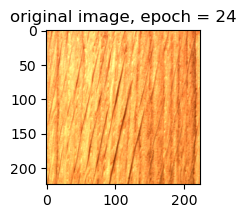

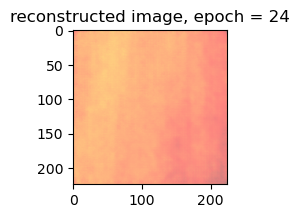

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


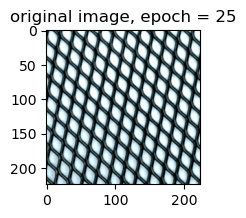

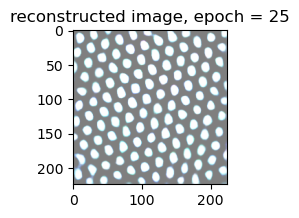

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


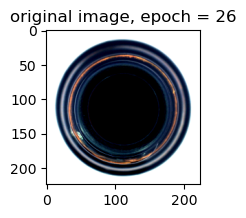

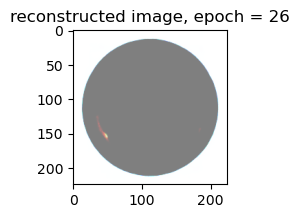

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


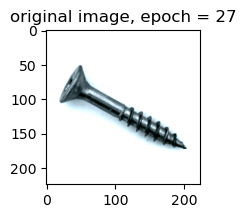

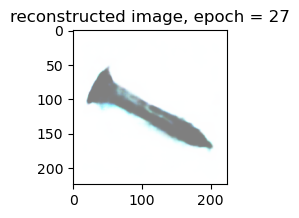

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


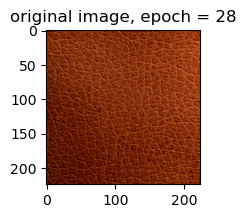

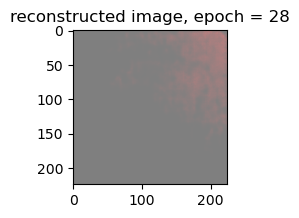

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


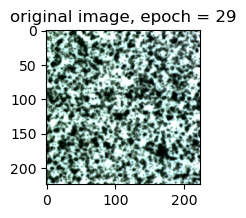

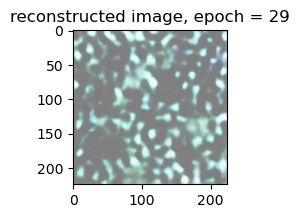

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


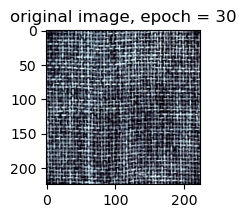

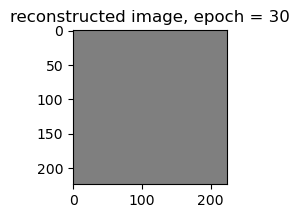

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


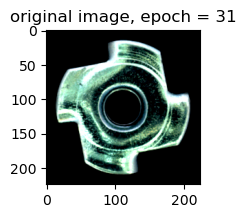

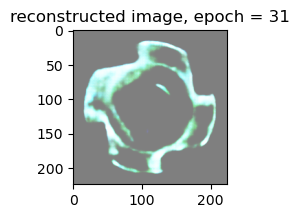

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


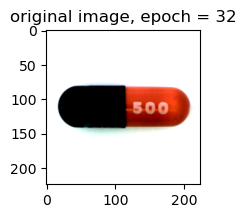

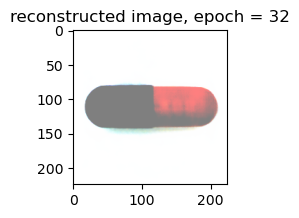

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


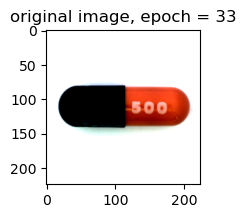

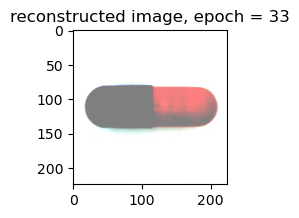

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


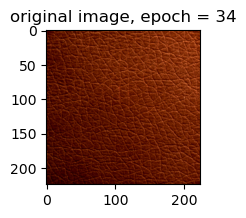

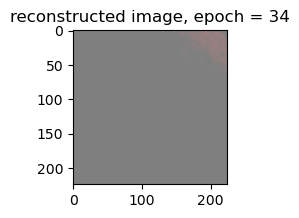

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


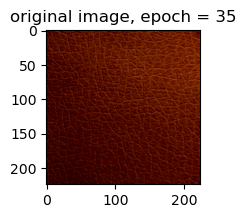

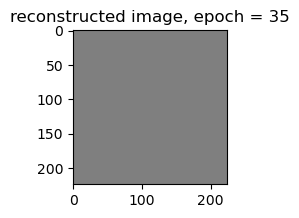

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


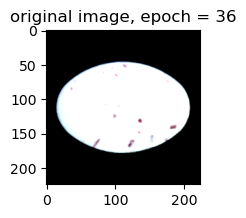

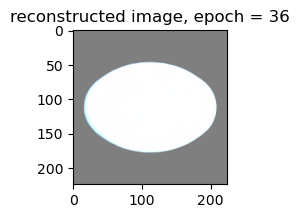

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


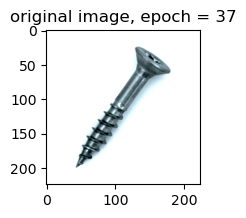

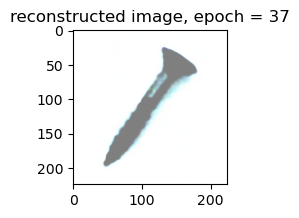

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


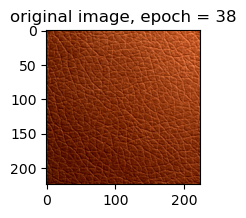

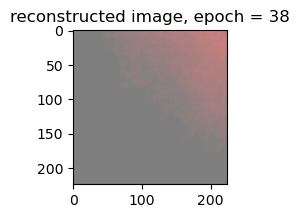

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


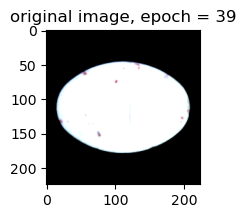

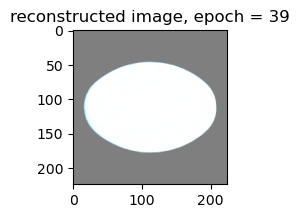

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


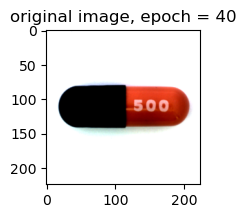

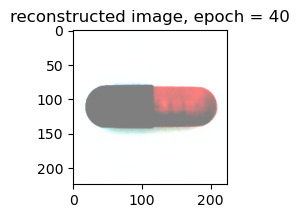

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


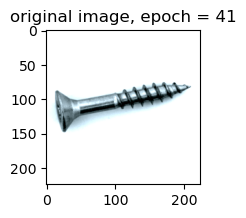

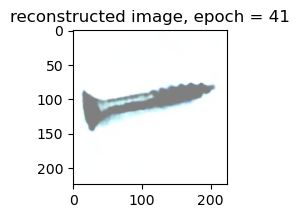

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


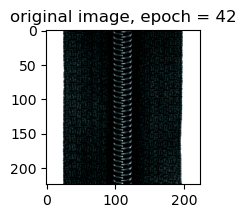

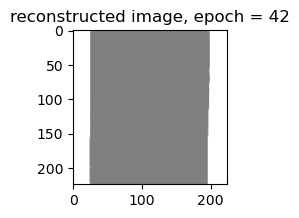

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


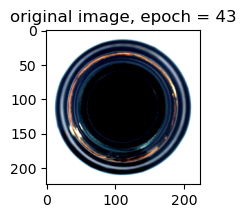

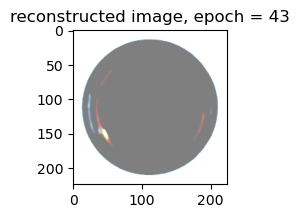

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


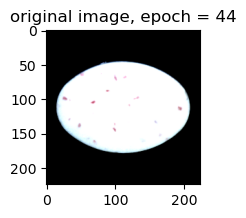

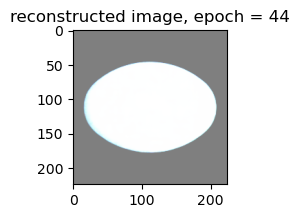

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


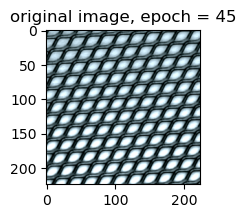

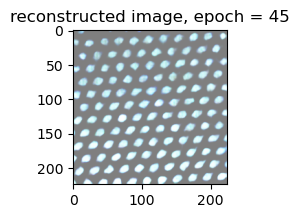

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


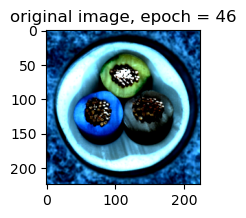

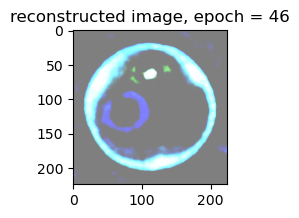

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


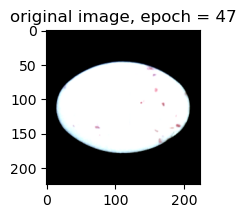

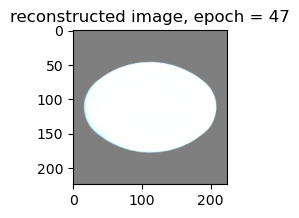

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


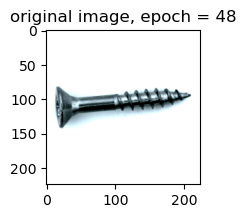

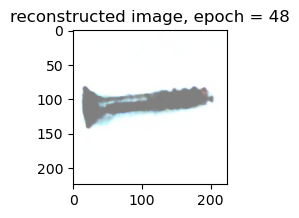

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


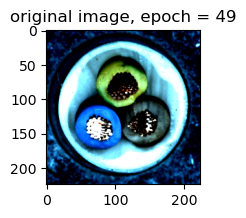

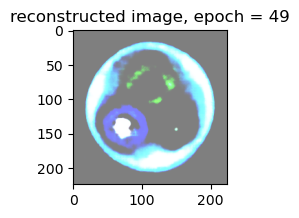

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


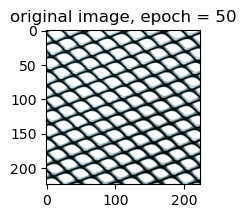

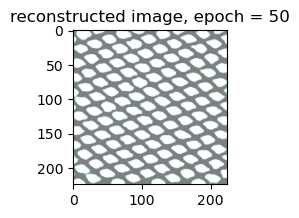

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


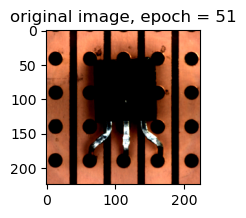

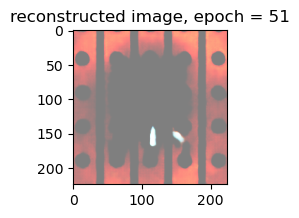

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


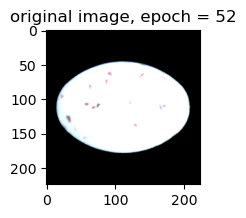

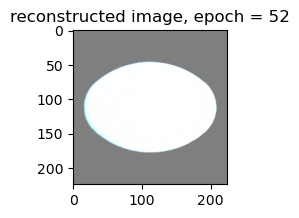

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


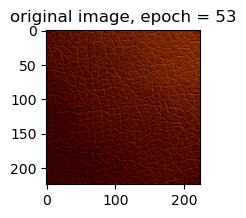

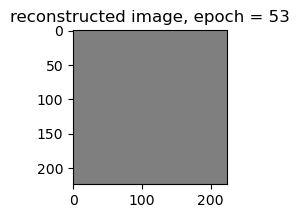

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


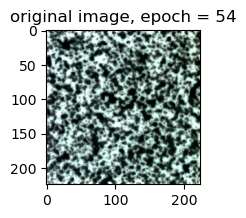

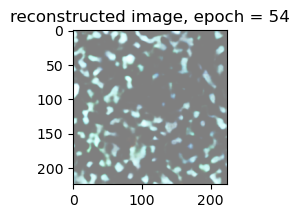

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


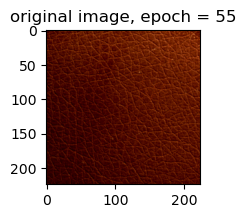

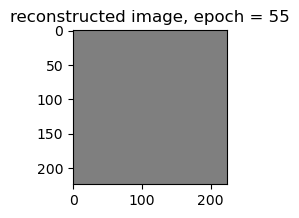

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


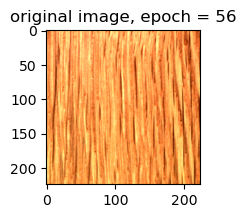

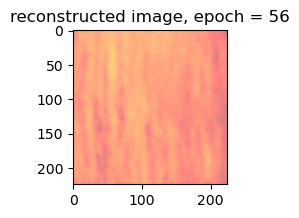

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


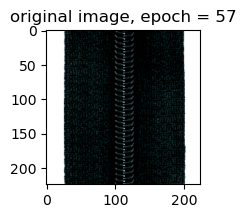

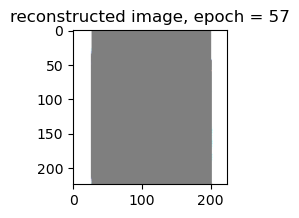

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


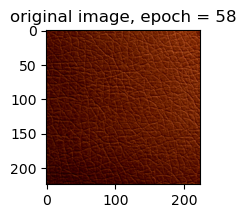

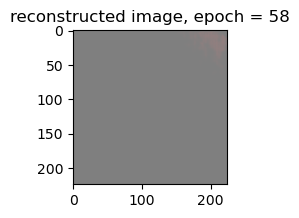

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


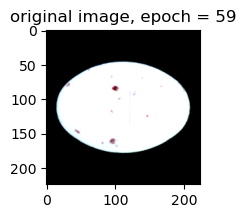

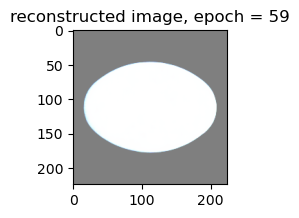

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


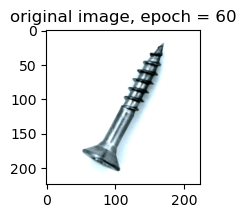

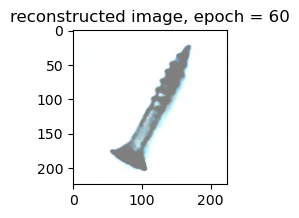

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


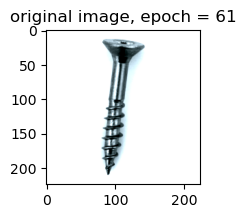

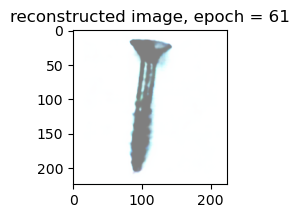

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


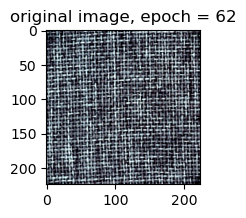

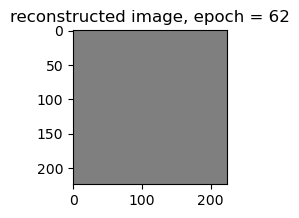

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


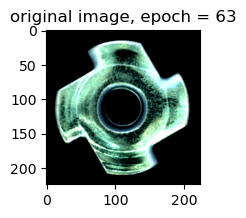

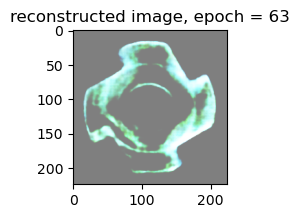

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


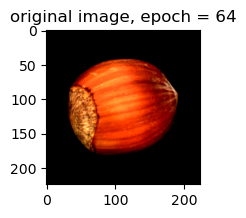

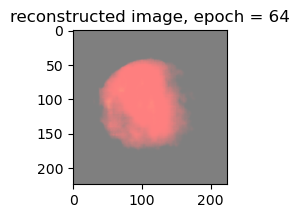

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


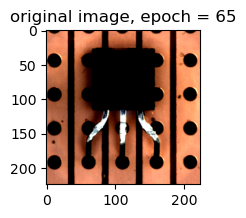

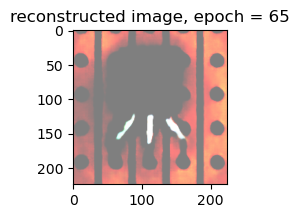

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


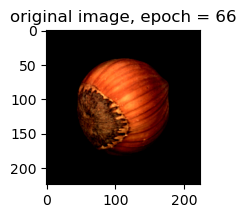

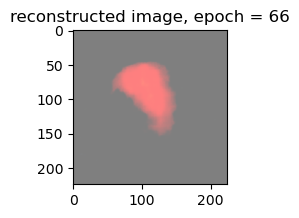

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


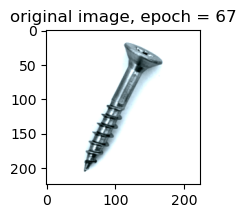

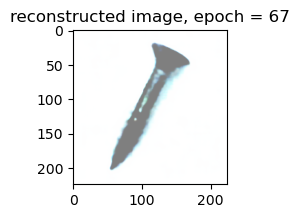

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


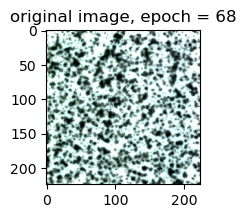

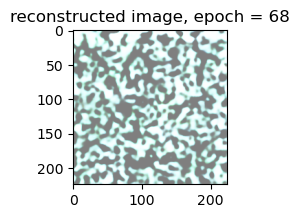

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


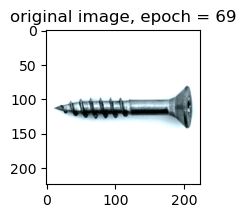

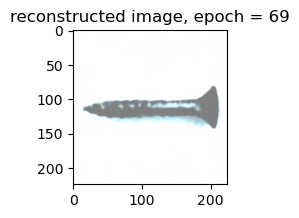

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


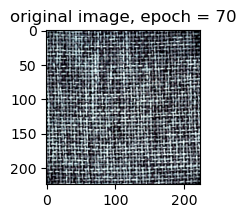

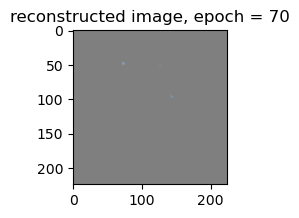

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


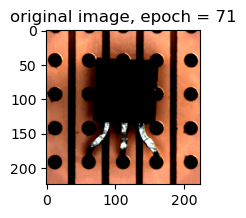

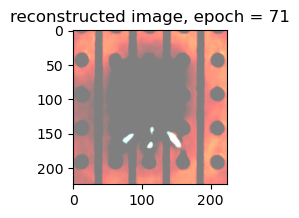

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


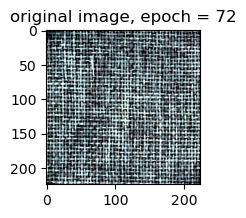

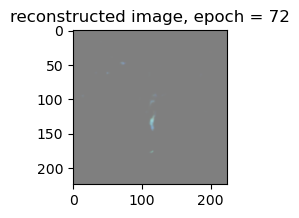

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


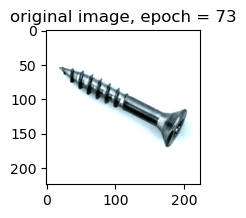

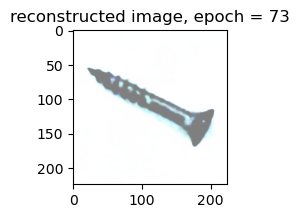

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


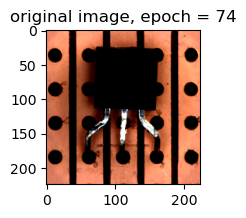

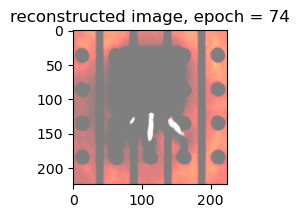

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


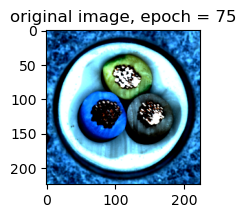

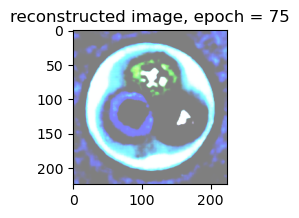

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


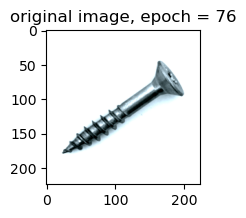

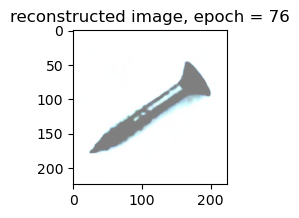

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


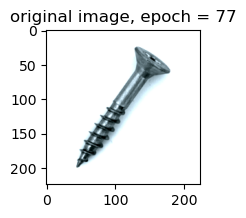

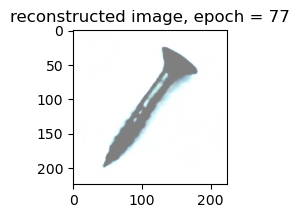

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


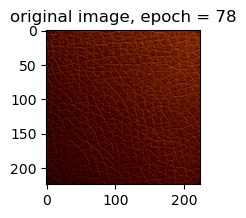

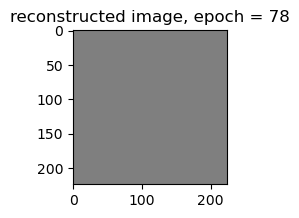

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


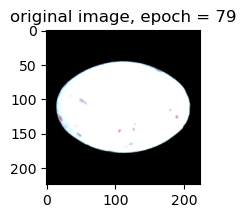

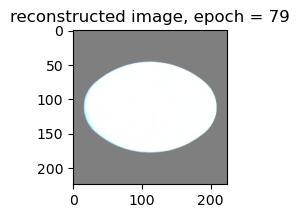

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


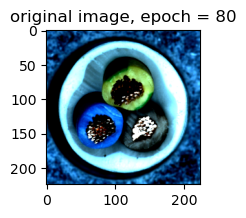

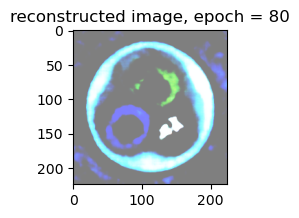

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


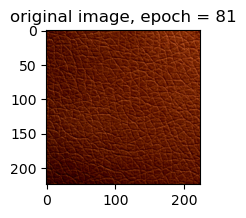

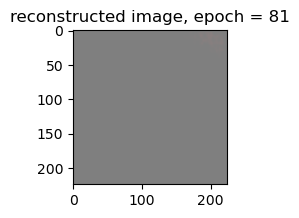

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


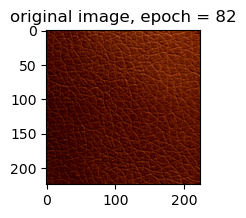

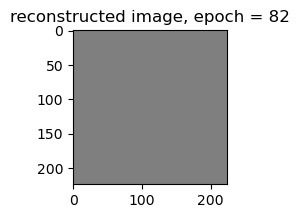

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


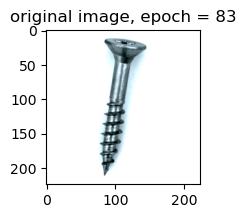

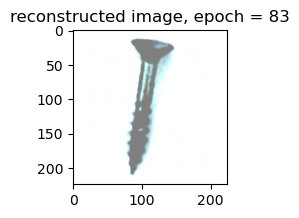

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


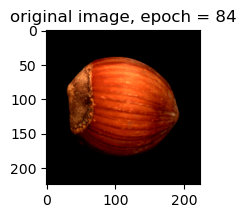

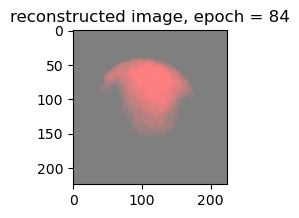

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


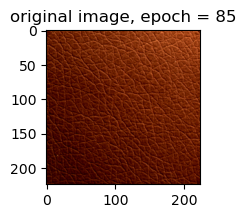

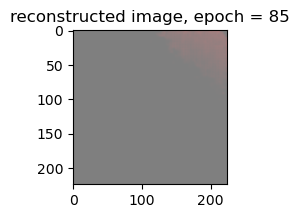

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


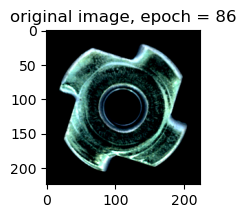

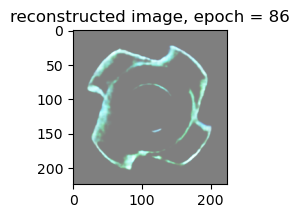

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


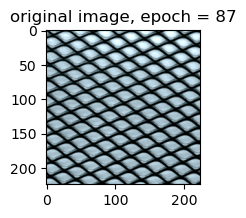

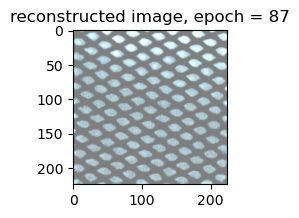

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


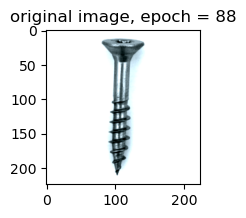

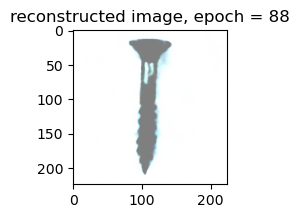

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


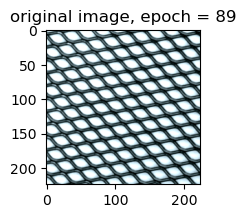

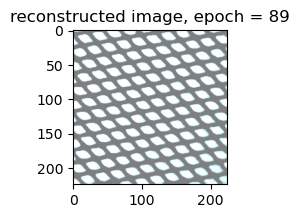

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


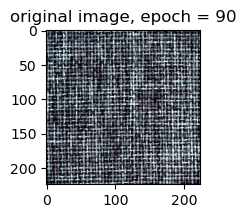

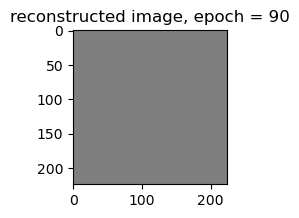

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


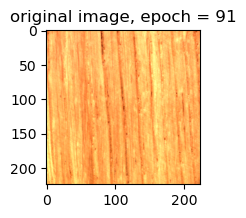

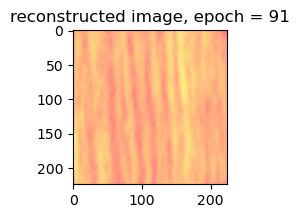

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


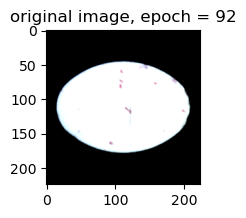

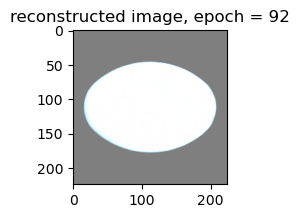

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


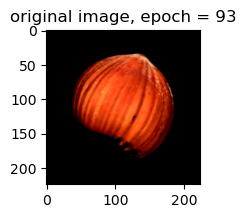

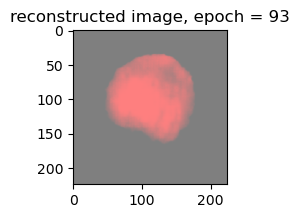

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


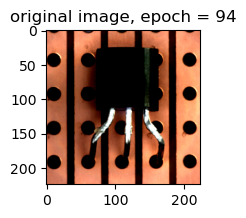

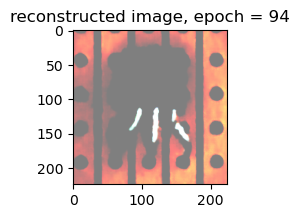

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


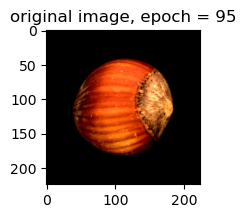

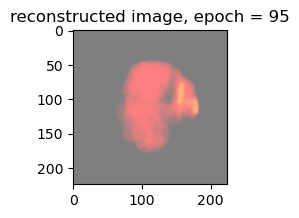

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


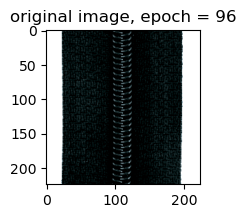

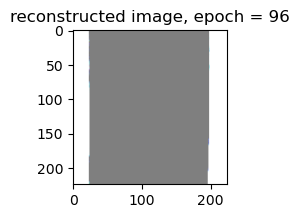

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


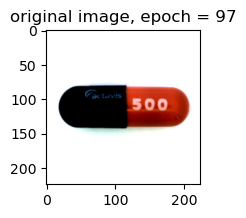

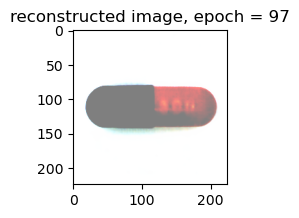

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


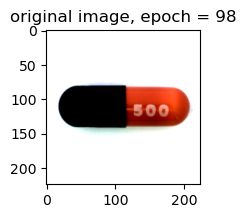

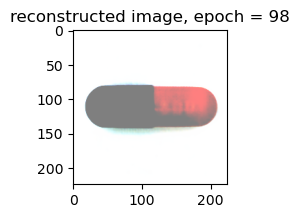

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


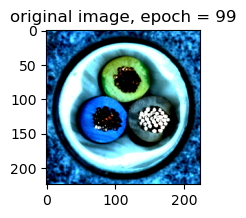

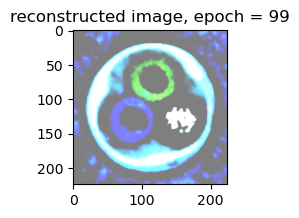

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


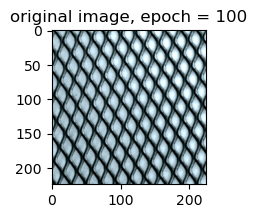

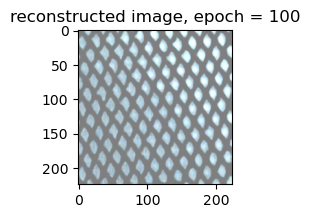

In [12]:
for k in range(0, EPOCHS):
    plt.figure(figsize=(10, 2))
    plt.title("original image, epoch = {}".format(k+1))
    imgs = output_train[k][1].cpu()
    recon = output_train[k][2].detach().cpu()
    for i, item in enumerate(imgs):
        item = item.reshape(3,224,224) # -> use for Autoencoder_Linear
        imshow(item)
    plt.figure(figsize=(10, 2))  
    plt.title("reconstructed image, epoch = {}".format(k+1))      
    for i, item in enumerate(recon):
        item = item.reshape(3, 224,224) # -> use for Autoencoder_Linear
        imshow(item)

In [13]:
test_loss = []
output_test = []

with torch.no_grad():
  for (img, _) in test_loader:
    # img = img.reshape(-1, 224*224*3)
    img = img.to(device)
    recon = model(img)
    loss = criterion(recon, img)
    test_loss.append(loss.item())
    
  print(f'Loss:{loss.item():.4f}')
  output_test.append((epoch, img, recon))

Loss:2.0143


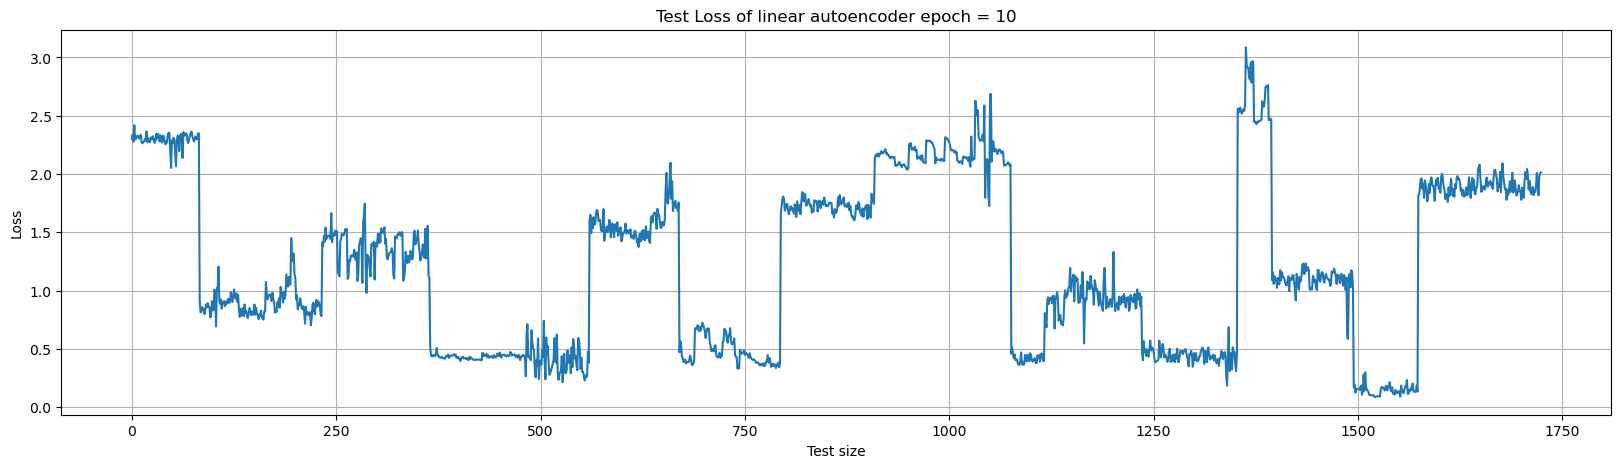

In [14]:
plt.figure(figsize=(20,5))
plt.plot(test_loss)
plt.grid()
plt.xlabel('Test size')
plt.ylabel('Loss')
plt.title('Test Loss of linear autoencoder epoch = 10')
plt.legend
plt.show()

In [15]:
print(len(test_loss))

1725


In [16]:
import pandas as pd

label_list = []

df_trainloss = pd.DataFrame({'train_loss':train_loss,'label':'good'})

dict = test_dataset.class_to_idx

dataiter = iter(test_loader)
for i in range(len(test_loader)):
    _, labels = next(dataiter)
    label_list.append(labels.numpy())

df_testloss = pd.DataFrame({'test_loss':test_loss,'label':label_list, 'True':None, 'Predicted':None})
df_testloss['label'] = df_testloss['label'].astype('int32')

In [17]:
def findKey(value):
    key = {v:k for k,v in dict.items()}
    return key.get(value)

for i in range(len(test_loss)):
    df_testloss['label'][i] = findKey(df_testloss['label'][i])

/tmp/ipykernel_3543483/3444478992.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['label'][i] = findKey(df_testloss['label'][i])


In [18]:
df_testloss

test_loss                  label  True Predicted
0      2.301062    bottle_broken_large  None      None
1      2.338082    bottle_broken_large  None      None
2      2.276922    bottle_broken_large  None      None
3      2.418846    bottle_broken_large  None      None
4      2.296941    bottle_broken_large  None      None
...         ...                    ...   ...       ...
1720   1.888499  zipper_squeezed_teeth  None      None
1721   1.817359  zipper_squeezed_teeth  None      None
1722   1.980395  zipper_squeezed_teeth  None      None
1723   2.006059  zipper_squeezed_teeth  None      None
1724   2.014337  zipper_squeezed_teeth  None      None

[1725 rows x 4 columns]

In [19]:
for i in range(len(test_loss)):
    if 'good' in df_testloss['label'][i]:
        # print(i)
        df_testloss['True'][i] = 'normal'
    else:
        df_testloss['True'][i] = 'anomaly'

df_testloss.head(70)

/tmp/ipykernel_3543483/676495749.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['True'][i] = 'anomaly'
/tmp/ipykernel_3543483/676495749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['True'][i] = 'normal'


test_loss                label     True Predicted
0    2.301062  bottle_broken_large  anomaly      None
1    2.338082  bottle_broken_large  anomaly      None
2    2.276922  bottle_broken_large  anomaly      None
3    2.418846  bottle_broken_large  anomaly      None
4    2.296941  bottle_broken_large  anomaly      None
..        ...                  ...      ...       ...
65   2.329243          bottle_good   normal      None
66   2.349420          bottle_good   normal      None
67   2.343288          bottle_good   normal      None
68   2.289807          bottle_good   normal      None
69   2.265201          bottle_good   normal      None

[70 rows x 4 columns]

In [20]:
print("Length of test loss : {}".format(len(test_loss)))

Length of test loss : 1725


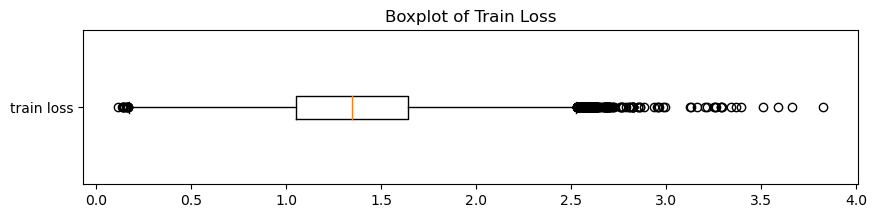

         train_loss
count  90800.000000
mean       1.351316
std        0.425644
min        0.116709
25%        1.051931
50%        1.345760
75%        1.642570
max        3.826479
Length of train loss : 90800
Frequency of loss more than 3QR : train_loss    22700
label         22700
dtype: int64


In [21]:
plt.figure(figsize=(10,2))
plt.boxplot(df_trainloss['train_loss'], vert = 0)
plt.title("Boxplot of Train Loss")
plt.yticks([1],["train loss"])
plt.show()

print(df_trainloss.describe())
trainloss_75 = np.percentile(df_trainloss['train_loss'], 75)
trainloss_25 = np.percentile(df_trainloss['train_loss'], 25)

print("Length of train loss : {}".format(len(train_loss)))
print("Frequency of loss more than 3QR : {}".format(df_trainloss[(df_trainloss['train_loss'] > trainloss_75)].count()))

In [22]:
print("Length of test : {}".format(len(test_loss)))

Length of test : 1725


In [23]:
threshold = np.percentile(df_trainloss['train_loss'], 75)
threshold

1.6425698399543762

In [24]:
for i in range(len(test_loss)):
    if df_testloss['test_loss'][i]>threshold:
        df_testloss['Predicted'][i] = 'anomaly'
    else:
        df_testloss['Predicted'][i] = 'normal'

df_testloss

/tmp/ipykernel_3543483/1336415062.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'anomaly'
/tmp/ipykernel_3543483/1336415062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'normal'


test_loss                  label     True Predicted
0      2.301062    bottle_broken_large  anomaly   anomaly
1      2.338082    bottle_broken_large  anomaly   anomaly
2      2.276922    bottle_broken_large  anomaly   anomaly
3      2.418846    bottle_broken_large  anomaly   anomaly
4      2.296941    bottle_broken_large  anomaly   anomaly
...         ...                    ...      ...       ...
1720   1.888499  zipper_squeezed_teeth  anomaly   anomaly
1721   1.817359  zipper_squeezed_teeth  anomaly   anomaly
1722   1.980395  zipper_squeezed_teeth  anomaly   anomaly
1723   2.006059  zipper_squeezed_teeth  anomaly   anomaly
1724   2.014337  zipper_squeezed_teeth  anomaly   anomaly

[1725 rows x 4 columns]

In [25]:
print(df_testloss['True'].value_counts())
print(df_testloss['Predicted'].value_counts())

anomaly    1258
normal      467
Name: True, dtype: int64
normal     1147
anomaly     578
Name: Predicted, dtype: int64


In [26]:
TP = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'anomaly')].count()
TP = TP[0]

FN = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'normal')].count()
FN = FN[0]

FP = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'anomaly')].count()
FP = FP[0]

TN = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'normal')].count()
TN = TN[0]

In [27]:
accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy is {}".format(accuracy))
print("Precision is {}".format(precision))
print("Recall is {}".format(recall))
print("F1 score is {}".format(f1_score))

Accuracy is 0.48057971014492756
Precision is 0.8131487889273357
Recall is 0.37360890302066774
F1 score is 0.5119825708061002


In [28]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(df_testloss['True'], df_testloss['Predicted'])
cf

array([[470, 788],
       [108, 359]])

Text(0.5, 1.0, 'Confusion Matrix')

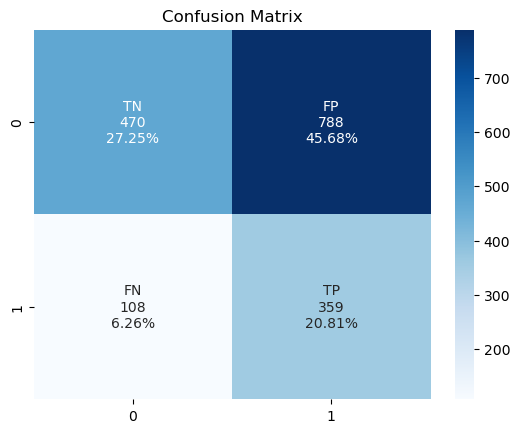

In [29]:
import seaborn as sns

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")

Accuracy is 0.5101449275362319
Precision is 0.7771812080536913
Recall is 0.46025437201907793
F1 score is 0.5781328007988018
[[579 679]
 [166 301]]


/tmp/ipykernel_3543483/3748311953.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'anomaly'
/tmp/ipykernel_3543483/3748311953.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'normal'


Text(0.5, 1.0, 'Confusion Matrix')

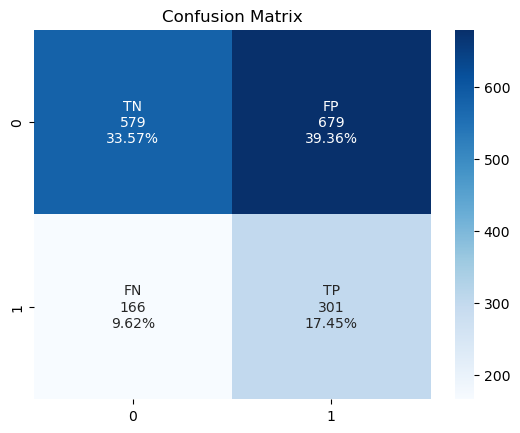

In [30]:
# threshold = 50

threshold = np.percentile(df_trainloss['train_loss'], 50)

for i in range(len(test_loss)):
    if df_testloss['test_loss'][i]>threshold:
        df_testloss['Predicted'][i] = 'anomaly'
    else:
        df_testloss['Predicted'][i] = 'normal'

TP = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'anomaly')].count()
TP = TP[0]

FN = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'normal')].count()
FN = FN[0]

FP = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'anomaly')].count()
FP = FP[0]

TN = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'normal')].count()
TN = TN[0]

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy is {}".format(accuracy))
print("Precision is {}".format(precision))
print("Recall is {}".format(recall))
print("F1 score is {}".format(f1_score))

cf = confusion_matrix(df_testloss['True'], df_testloss['Predicted'])
print(cf)

import seaborn as sns

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")

/tmp/ipykernel_3543483/420772052.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'anomaly'
/tmp/ipykernel_3543483/420772052.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'normal'


Accuracy is 0.5339130434782609
Precision is 0.7516629711751663
Recall is 0.5389507154213037
F1 score is 0.6277777777777779
[[678 580]
 [224 243]]


Text(0.5, 1.0, 'Confusion Matrix')

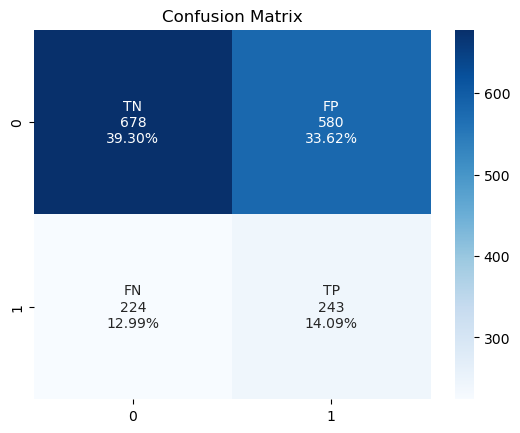

In [31]:
# threshold = 25

threshold = np.percentile(df_trainloss['train_loss'], 25)

for i in range(len(test_loss)):
    if df_testloss['test_loss'][i]>threshold:
        df_testloss['Predicted'][i] = 'anomaly'
    else:
        df_testloss['Predicted'][i] = 'normal'

TP = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'anomaly')].count()
TP = TP[0]

FN = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'normal')].count()
FN = FN[0]

FP = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'anomaly')].count()
FP = FP[0]

TN = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'normal')].count()
TN = TN[0]

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy is {}".format(accuracy))
print("Precision is {}".format(precision))
print("Recall is {}".format(recall))
print("F1 score is {}".format(f1_score))

cf = confusion_matrix(df_testloss['True'], df_testloss['Predicted'])
print(cf)

import seaborn as sns

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")

/tmp/ipykernel_3543483/141051450.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'anomaly'
/tmp/ipykernel_3543483/141051450.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'normal'


Accuracy is 0.5095652173913043
Precision is 0.7768817204301075
Recall is 0.4594594594594595
F1 score is 0.5774225774225775
[[578 680]
 [166 301]]


Text(0.5, 1.0, 'Confusion Matrix')

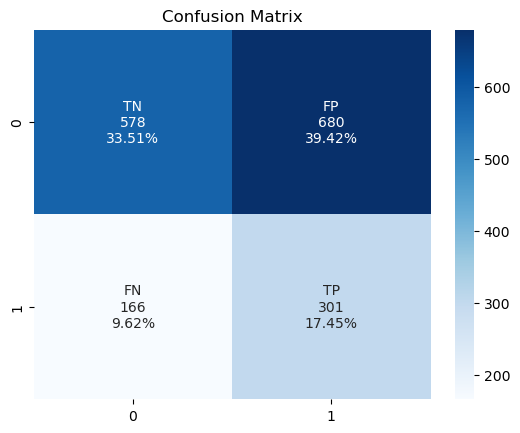

In [32]:
# threshold = avg of train loss

threshold = df_trainloss['train_loss'].mean()

for i in range(len(test_loss)):
    if df_testloss['test_loss'][i]>threshold:
        df_testloss['Predicted'][i] = 'anomaly'
    else:
        df_testloss['Predicted'][i] = 'normal'

TP = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'anomaly')].count()
TP = TP[0]

FN = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'normal')].count()
FN = FN[0]

FP = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'anomaly')].count()
FP = FP[0]

TN = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'normal')].count()
TN = TN[0]

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy is {}".format(accuracy))
print("Precision is {}".format(precision))
print("Recall is {}".format(recall))
print("F1 score is {}".format(f1_score))

cf = confusion_matrix(df_testloss['True'], df_testloss['Predicted'])
print(cf)

import seaborn as sns

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")

Accuracy is 0.527536231884058
Precision is 0.7807351077313055
Recall is 0.48966613672496023
F1 score is 0.6018563751831949
[[616 642]
 [173 294]]


/tmp/ipykernel_3543483/3055069119.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'anomaly'
/tmp/ipykernel_3543483/3055069119.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testloss['Predicted'][i] = 'normal'


Text(0.5, 1.0, 'Confusion Matrix')

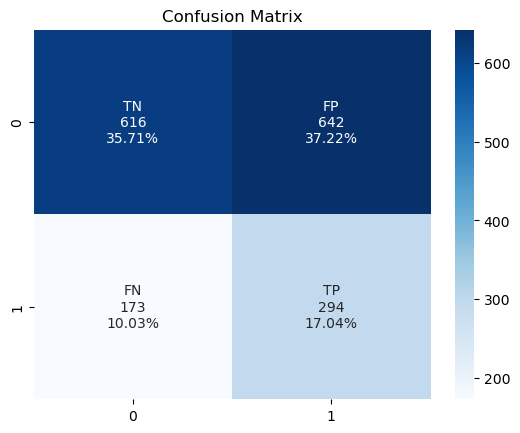

In [33]:
# threshold = avg of test loss

threshold = df_testloss['test_loss'].mean()

for i in range(len(test_loss)):
    if df_testloss['test_loss'][i]>threshold:
        df_testloss['Predicted'][i] = 'anomaly'
    else:
        df_testloss['Predicted'][i] = 'normal'

TP = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'anomaly')].count()
TP = TP[0]

FN = df_testloss[(df_testloss['True'] == 'anomaly') & (df_testloss['Predicted'] == 'normal')].count()
FN = FN[0]

FP = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'anomaly')].count()
FP = FP[0]

TN = df_testloss[(df_testloss['True'] == 'normal') & (df_testloss['Predicted'] == 'normal')].count()
TN = TN[0]

accuracy = (TP+TN)/(TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy is {}".format(accuracy))
print("Precision is {}".format(precision))
print("Recall is {}".format(recall))
print("F1 score is {}".format(f1_score))

cf = confusion_matrix(df_testloss['True'], df_testloss['Predicted'])
print(cf)

import seaborn as sns

group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf.flatten()/np.sum(cf)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')
plt.title("Confusion Matrix")